# Nested Logit Model

In [1]:
import pandas as pd
import numpy as np
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.optimization as opt
from biogeme.expressions import Beta, DefineVariable
import seaborn as sns
import matplotlib.pyplot as plt

**Import Optima data**

In [2]:
pandas = pd.read_csv("../../Data/8-DiscreteChoiceModels/optima.dat",sep='\t')
database = db.Database ("data/optima", pandas)

**Use collumn names as variables**

In [3]:
globals().update(database.variables)

## Let's see what this dataset has

* Estimation of a mode choice behavior model for inhabitants in Switzerland using revealed preference data
* Objective was to show the market potential for combined mobility, especially within agglomerations, taking into account the factors that influence travellers in their choice of transport
* The survey was conducted between 2009 and 2010 for CarPostal, the public transport branch of the Swiss Postal Service
* 1124 completed surveys were collected. For each respondent, cyclic sequences of trips (starting and ending at the same location) are detected and their main transport mode is identified. The resulting data base includes 1906 sequences of trips linked with psychometric indicators and socio-economic attributes of the respondents.

![](img/optima_var1.png)

![](img/optima_var2.png)

**Exclude some unwanted entries**

In [4]:
exclude = (Choice == -1.)
database.remove(exclude)

**Define some dummy variables**

In [5]:
male = (Gender == 1)
female = (Gender == 2)
unreportedGender = (Gender == -1)

fulltime = (OccupStat == 1)
notfulltime = (OccupStat != 1)

**Rescale some data**

In [6]:
TimePT_scaled = TimePT / 200
TimeCar_scaled = TimeCar / 200
MarginalCostPT_scaled = MarginalCostPT / 10 
CostCarCHF_scaled = CostCarCHF / 10
distance_km_scaled = distance_km / 5

And many more variables...

In [7]:
pandas = database.data

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

pandas.describe()

,ID,DestAct,NbTransf,TimePT,WalkingTimePT,WaitingTimePT,CostPT,CostCar,TimeCar,NbHousehold,NbChild,NbCar,NbMoto,NbBicy,NbBicyChild,NbComp,NbTV,Internet,NewsPaperSubs,NbCellPhones,NbSmartPhone,HouseType,OwnHouse,NbRoomsHouse,YearsInHouse,Income,Gender,BirthYear,Mothertongue,FamilSitu,OccupStat,SocioProfCat,CalculatedIncome,Education,HalfFareST,LineRelST,GenAbST,AreaRelST,OtherST,CarAvail,MarginalCostPT,CostCarCHF,Envir01,Envir02,Envir03,Envir04,Envir05,Envir06,Mobil01,Mobil02,Mobil03,Mobil04,Mobil05,Mobil06,Mobil07,Mobil08,Mobil09,Mobil10,Mobil11,Mobil12,Mobil13,Mobil14,Mobil15,Mobil16,Mobil17,Mobil18,Mobil19,Mobil20,Mobil21,Mobil22,Mobil23,Mobil24,Mobil25,Mobil26,Mobil27,ResidCh01,ResidCh02,ResidCh03,ResidCh04,ResidCh05,ResidCh06,ResidCh07,LifSty01,LifSty02,LifSty03,LifSty04,LifSty05,LifSty06,LifSty07,LifSty08,LifSty09,LifSty10,LifSty11,LifSty12,LifSty13,LifSty14,TripPurpose,TypeCommune,UrbRur,LangCode,ClassifCodeLine,frequency,ResidChild,NbTrajects,FreqCarPar,FreqTrainPar,FreqOtherPar,FreqTripHouseh,Region,distance_km,Choice,InVehicleTime,ModeToSchool,ReportedDuration,CoderegionCAR,age,Weight
count,1.906000e+03,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000
mean,4.587880e+07,4.218783,2.007870,107.882476,39.625393,13.125393,18.853122,4.018431,40.675236,2.609129,0.455929,1.363589,0.182057,2.483736,0.435992,1.657398,1.196222,0.977440,1.119622,2.087618,0.206716,1.172088,1.168940,4.681532,13.892445,3.701469,1.360441,1842.123295,1.188877,2.620672,3.146905,4.157922,7880.547744,3.941763,1.518363,1.940189,1.911333,1.927597,1.955929,1.101259,11.105404,5.758499,2.524659,3.141133,2.733998,2.443861,3.416055,4.059286,3.908709,2.995803,3.241343,4.081322,3.251836,3.493704,3.792760,2.261805,3.694648,3.785939,3.550367,1.922350,4.107555,3.047219,3.727702,3.271249,3.440714,2.813746,3.639035,3.431794,3.243442,2.535152,4.019937,3.262854,2.139559,3.087618,3.121196,2.467471,3.527807,3.070829,2.969570,1.565058,2.407660,3.947534,2.462225,2.784365,3.539874,3.596537,3.645855,2.790661,2.232949,4.001049,2.432844,2.684680,2.683106,3.179433,3.482162,3.396118,1.935467,5.394544,1.505247,1.744491,3.165792,2.843127,3.923924,2.044596,2.057712,1.510493,1.574502,2.726653,4.578699,40.378757,0.778594,55.269675,3.756034,57.725079,4.578699,46.481112,0.000427
std,2.384691e+07,3.535628,2.170535,86.520629,27.999199,22.073856,23.666168,5.817255,47.612389,1.481257,1.068960,0.890024,0.746585,1.954334,1.163011,1.331090,0.969512,0.507182,0.628595,1.461019,0.806325,0.674062,0.648682,1.985008,12.845272,1.957707,0.721393,467.378286,0.764022,1.634398,3.224485,2.627481,4078.861884,2.030804,0.499794,0.237199,0.284338,0.259222,0.205308,0.761080,16.130519,8.336017,

C:\code\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


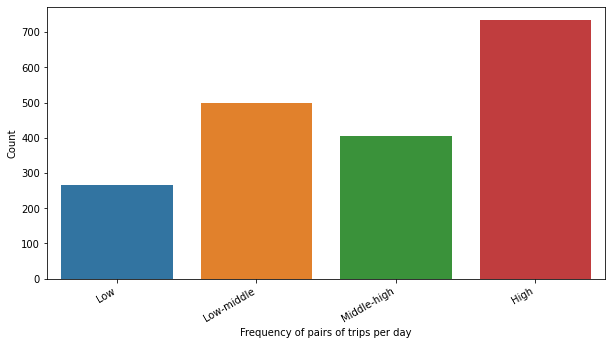

In [8]:
plt.figure(figsize=(10,5))
chart = sns.countplot(pandas['frequency'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');
chart.set_xticklabels(['Low', 'Low-middle', 'Middle-high', 'High']);
chart.set(xlabel="Frequency of pairs of trips per day", ylabel = "Count");

C:\code\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


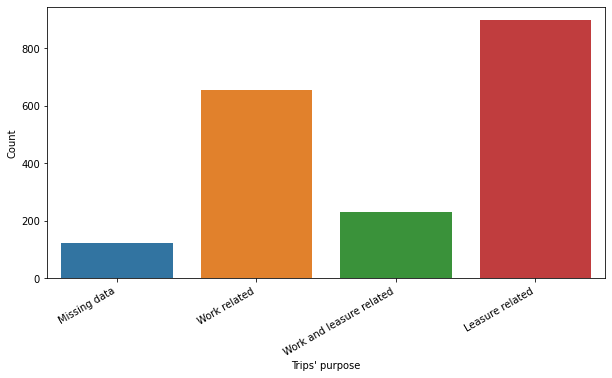

In [9]:
plt.figure(figsize=(10,5))
chart = sns.countplot(pandas['TripPurpose'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');
chart.set_xticklabels(['Missing data',
                            'Work related', 
                            'Work and leasure related',
                            'Leasure related']);
chart.set(xlabel="Trips' purpose", ylabel = "Count");

C:\code\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


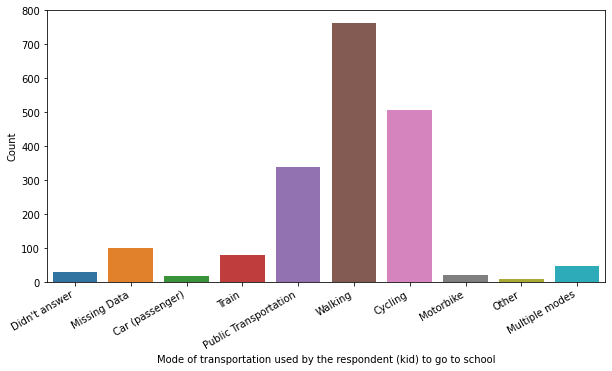

In [10]:
plt.figure(figsize=(10,5))
chart = sns.countplot(pandas['ModeToSchool'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');
chart.set_xticklabels(['Didn\'t answer', 'Missing Data', 'Car (passenger)', 'Train', 'Public Transportation',  'Walking', 'Cycling', 'Motorbike', 'Other', 'Multiple modes']);
chart.set(xlabel="Mode of transportation used by the respondent (kid) to go to school", ylabel = "Count");

**Define the utility functions**

\begin{align}
V_{PT} & = \beta_{PT} + \beta_{time_{fulltime}} X_{time_{PT}} X_{fulltime} + \beta_{time_{other}} X_{time_{PT}} X_{not\_fulltime} + \beta_{cost} X_{cost_{PT}} \\
V_{car} & = \beta_{car} + \beta_{time_{fulltime}} X_{time_{car}} X_{fulltime} + \beta_{time_{other}} X_{time_{car}} X_{not\_fulltime} + \beta_{cost} X_{cost_{car}} \\
V_{SM} & = \beta_{SM} + \beta_{male} X_{distance} X_{male} + \beta_{female} X_{distance} X_{female} + \beta_{unreported} X_{distance} X_{unreported}
\end{align}

**Create parameters to be estimated**

In [11]:
ASC_CAR              = Beta('ASC_CAR',0,None,None,0)
ASC_PT               = Beta('ASC_PT',0,None,None,1)
ASC_SM               = Beta('ASC_SM',0,None,None,0)
BETA_TIME_FULLTIME   = Beta('BETA_TIME_FULLTIME',0,None,None,0)
BETA_TIME_OTHER      = Beta('BETA_TIME_OTHER',0,None,None,0)
BETA_DIST_MALE       = Beta('BETA_DIST_MALE',0,None,None,0)
BETA_DIST_FEMALE     = Beta('BETA_DIST_FEMALE',0,None,None,0)
BETA_DIST_UNREPORTED = Beta('BETA_DIST_UNREPORTED',0,None,None,0)
BETA_COST            = Beta('BETA_COST',0,None,None,0)

**Define the utility functions**

In [12]:
V_PT = ASC_PT + BETA_TIME_FULLTIME * TimePT_scaled * fulltime + \
       BETA_TIME_OTHER * TimePT_scaled * notfulltime + \
       BETA_COST * MarginalCostPT_scaled
V_CAR = ASC_CAR + \
        BETA_TIME_FULLTIME * TimeCar_scaled * fulltime + \
        BETA_TIME_OTHER * TimeCar_scaled * notfulltime + \
        BETA_COST * CostCarCHF_scaled
V_SM = ASC_SM + \
       BETA_DIST_MALE * distance_km_scaled * male + \
       BETA_DIST_FEMALE * distance_km_scaled * female + \
       BETA_DIST_UNREPORTED * distance_km_scaled * unreportedGender

**Associate utility functions with alternatives and associate availability of alternatives**

In this example all alternatives are available for each individual

In [13]:
V = {0: V_PT,
     1: V_CAR,
     2: V_SM}

av = {0: 1,
      1: 1,
      2: 1}

**Define the nests**

1. Define the nests paramenters
2. List alternatives in nests

In [14]:
MU_NO_CAR = Beta('MU_NO_CAR', 1.,1.,None,0)

CAR_NEST = 1., [1]
NO_CAR_NEST = MU_NO_CAR, [0, 2]

nests = CAR_NEST, NO_CAR_NEST

**Define the model**

In [15]:
logprob = models.lognested (V, av , nests , Choice )

**Define the Biogeme object**

In [16]:
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = "optima_nested_logit"

**Estimate the model**

In [17]:
biogeme.generateHtml = True
biogeme.generatePickle = True

results = biogeme.estimate(bootstrap=100)

print(f"HTML file:    {results.data.htmlFileName}")
print(f"Pickle file:  {results.data.pickleFileName }")

HTML file:    optima_nested_logit.html
Pickle file:  optima_nested_logit.pickle


**Print results**

In [18]:
print("Estimated betas: {}".format(len(results.data.betaValues)))

betas = results.getBetaValues()
for k,v in betas.items():
    print("{}= {}".format(k.ljust(25),v))

Estimated betas: 9
ASC_CAR                  = 0.26147366856401844
ASC_SM                   = 0.05916112728375036
BETA_COST                = -0.7161889749188455
BETA_DIST_FEMALE         = -0.8310907964443561
BETA_DIST_MALE           = -0.6862284337817491
BETA_DIST_UNREPORTED     = -0.7029816707208786
BETA_TIME_FULLTIME       = -1.5962723241026053
BETA_TIME_OTHER          = -0.576830892041444
MU_NO_CAR                = 1.5287463169080127


**General Statistics**

In [19]:
gs = results.getGeneralStatistics()

for k,v in gs.items():
    print("{}= {}".format(k.ljust(45),v[0]))

Number of estimated parameters               = 9
Sample size                                  = 1906
Excluded observations                        = 359
Init log likelihood                          = -2093.9550222014136
Final log likelihood                         = -1298.4982835573562
Likelihood ratio test for the init. model    = 1590.9134772881148
Rho-square for the init. model               = 0.3798824378795773
Rho-square-bar for the init. model           = 0.37558435129004863
Akaike Information Criterion                 = 2614.9965671147124
Bayesian Information Criterion               = 2664.97142587264
Final gradient norm                          = 0.011044410781700216
Bootstrapping time                           = 0:00:51.884767
Nbr of threads                               = 8
